# Use EN4 climatological volume of isopycnals to construct a density/pressure relationship used for remapping data from density to a pseudo-depth coordinate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from netCDF4 import Dataset as open_ncfile
import time

In [3]:
# Read EN4 file : will be our climatology
indir = '/home/ericglod/Density_bining/test/'
file = 'EN4.mon.ocean.Omon.1900_2017.density.nc'#'obs.EN4.historical.r0i0p0.mo.ocn.Omon.density.ver-1.latestX_zon2D.nc'
f = open_ncfile(indir+file,'r')

# Read variables
lat = f.variables['latitude'][:]
density = f.variables['lev'][:]
isonvol = np.ma.average(f.variables['isonvol'][:,:,:,:],axis=0)*1.e03 # Volume of isopycnals in km3, make climatology

basinN=4
latN = len(lat)
densityN = len(density)

In [4]:
gridz = np.arange(0,5501,5)
gridz2 = np.concatenate([np.arange(0,21,1),np.arange(25,5501,5)])

# WOA13 grid
targetz = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
   85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375,
   400, 425, 450, 475, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950,
   1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550,
   1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2100, 2200, 2300,
   2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500,
   3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700,
   4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500]

In [32]:
# Read bathymetry
# Read masks
fmask = open_ncfile('/home/ysilvy/Density_bining/Yona_analysis/data/170224_WOD13_masks.nc','r')
basinmask = fmask.variables['basinmask3'][:] # (latitude, longitude)
depthmask = fmask.variables['depthmask'][:] # (latitude, longitude)
longitude = fmask.variables['longitude'][:]
# Create basin masks
mask_a = basinmask != 1
mask_p = basinmask != 2
mask_i = basinmask != 3
# Read bathy
depthmask_a = np.ma.array(depthmask, mask=mask_a) # Mask every basin except Atlantic
depthmask_p = np.ma.array(depthmask, mask=mask_p)
depthmask_i = np.ma.array(depthmask, mask=mask_i)
# Zonal bathy (for plotting afterwards)
bathy_a = np.ma.max(depthmask_a, axis=1)
bathy_p = np.ma.max(depthmask_p, axis=1)
bathy_i = np.ma.max(depthmask_i, axis=1)
# Read area
area = fmask.variables['basinmask3_area'][:] # (latitude,longitude)

In [6]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

## Start by calculating the theoretical volume of water in the ocean per depth level based on bathymetry

In [7]:
# Compute zonal volume on gridz2 levels (every 5 meters, every 1 meter at the surface)
V = np.ma.masked_all((basinN,len(gridz2),latN))
# Loop on Atlantic, Pacific and Indian basins
start_time = time.time()
for ibasin in range(1,4): 
    print(ibasin)
    if ibasin==1:
        depthmask = depthmask_a
    elif ibasin==2:
        depthmask = depthmask_p
    else:
        depthmask = depthmask_i
    for ilat in range(latN):
        area_lat = np.ma.average(area[ilat,:]) # Same area for all longitudes along ilat: take the average to make sure we don't choose a masked gridpoint
        # Loop on depths
        for iz in range(len(gridz2)):
            cells_above = np.argwhere(depthmask[ilat,:]>gridz2[iz]) #.squeeze() # list of indices where bathymetry is below the current z level
            if len(cells_above)!=0: #Exclude depths where there is no water
                S = len(cells_above)*area_lat # total area in km2 at depth gridz[iz] for the current band of latitude
                V[ibasin,iz,ilat] = S*0.001*(gridz2[iz+1]-gridz2[iz]) # Corresponding volume in km3 (5m interval for gridz, 1m at surface)

elapsed_time = time.time() - start_time

# Now compute volume for global zonal mean (ibasin=0)
V[0,:,:] = np.sum(V[1:,:,:],axis=0)

1
2
3


## Here just running some tests

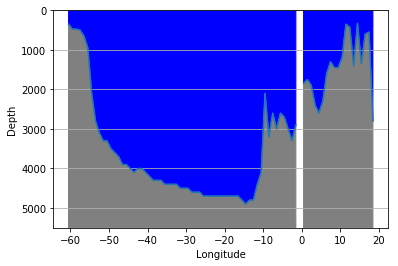

In [8]:
# Plot ocean for ibasin,ilat
ilat = 20
plt.plot(longitude,depthmask_a[ilat,:])
ax=plt.gca()
plt.ylim([0,5500])
plt.gca().invert_yaxis()
ax.fill_between(longitude,depthmask_a[ilat,:],color='blue')
ax.fill_between(longitude,depthmask_a[ilat,:],[5500]*len(longitude),color='grey')
plt.grid(axis='y')
plt.xlabel('Longitude')
plt.ylabel('Depth')
plt.show()
#depthmask_a[ilat,np.where(basinmask==1)]
#lat[ilat]

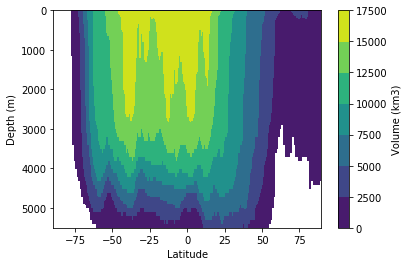

In [9]:
# Plot total volume
lat2d,z2d = np.meshgrid(lat,gridz2)
ax=plt.gca()
#ax.fill_between(lat,np.ma.max(depthmask_a,axis=1),[5500]*len(lat),color='grey')
plt.contourf(lat2d,z2d,V[0,:,:])
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
cb = plt.colorbar()
cb.set_label('Volume (km3)')
plt.show()

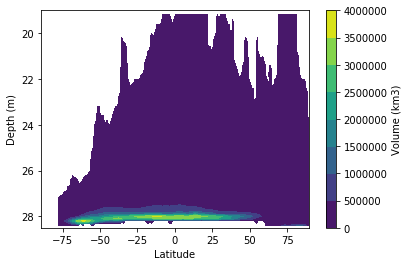

In [10]:
# Plot total volume of EN4 on isopycnals
lat2d,density2d = np.meshgrid(lat,density)
ax=plt.gca()
#ax.fill_between(lat,np.ma.max(depthmask_a,axis=1),[5500]*len(lat),color='grey')
plt.contourf(lat2d,density2d,isonvol[0,:,:])
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
cb = plt.colorbar()
cb.set_label('Volume (km3)')
plt.show()

In [11]:
# Computed volume of the ocean, based on WOA13 bathymetry
np.sum(V[0,:,:])/1.e09 #*10^9km3

1.352102832608972

In [12]:
# EN4 volume of the ocean
np.ma.sum(isonvol[0,:,:])/1.e09 #*10^9km3

1.4416839366345782

In [13]:
# Model volume of the ocean
indirh = '/data/ericglod/Density_binning/Prod_density_april15/mme_hist/'
fileh_2d = 'cmip5.CCSM4.historical.ensm.an.ocn.Omon.density.ver-v20121128_zon2D.nc' #'cmip5.CCSM4.historical.r1i1p1.an.ocn.Omon.density.ver-v20121128_zon2D.nc'#
fmod = open_ncfile(indirh+fileh_2d)
isonvol_mod = np.ma.average(fmod.variables['isonvol'][-100:,:,:,:],axis=0)*1.e03 # Volume of isopycnals in km3, make climatology
isonso = np.ma.average(fmod.variables['isonso'][-100:,:,:,:],axis=0)
np.ma.sum(isonvol_mod[0,:,:])/1.e09

1.683437518911395

In [14]:
indir = '/data/ericglod/Density_binning/Prod_density_april15/Raw/historical/correct/'
file = 'cmip5.CCSM4.historical.r1i1p1.an.ocn.Omon.density.ver-v20121128.nc'
f = open_ncfile(indir+file)
thickness = np.ma.average(f.variables['isonthickg'][-100:,:,:,:],axis=0)
np.ma.sum(thickness)

141515586.77881116

In [15]:
# # Initialize
# pseudo_depth = np.ma.masked_all(densityN)
# idx_pseudo_depth = np.ma.masked_all(densityN)
# idx_range = np.ma.flatnotmasked_edges(isonvol[ibasin,:,ilat]) # Indices edges of unmasked densities in the column
# bathy=np.ma.max(depthmask_a[ilat,:]) # Find max depth of the water column
# ibathy=np.argwhere(gridz2==bathy).squeeze() # Index of bathymetry = first masked value of the water column
# # ilev = 1
# for ilev in range(idx_range[0],idx_range[1]):
#     isonvol_lev = isonvol[ibasin,ilev,ilat]
#     if ilev != idx_range[0]:
#         cum_V_ref = cum_V-cum_V[np.int(idx_pseudo_depth[ilev-1])] # Corresponds to the cumulated volume starting at the previous z level found
#     else:
#         cum_V_ref = cum_V
#     iz = find_nearest(cum_V_ref,isonvol_lev) # Find z index of nearest volume on gridz
#     pseudo_depth[ilev] = gridz2[iz] # Save corresponding z level on gridz
#     idx_pseudo_depth[ilev] = iz # Save index for next step in the loop
#     print(ilev,density[ilev],iz,gridz2[iz],isonvol_lev,cum_V_ref[iz])
# #ilev = idx_range[1]
# #pseudo_depth[ilev] = 

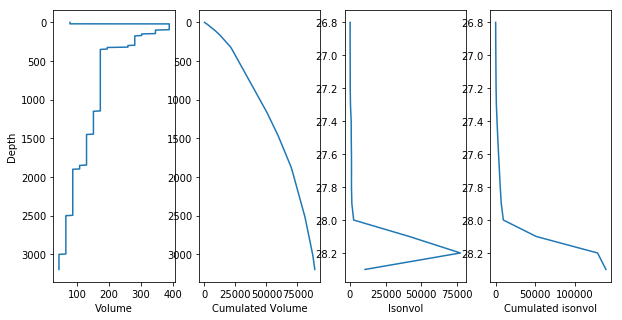

In [18]:
cum_V = np.ma.cumsum(V[ibasin,:,ilat])
fig,ax = plt.subplots(1,4,figsize=(10,5))
ax[0].plot(V[ibasin,:,ilat],gridz2,label='Volume')
ax[0].set_xlabel('Volume')
ax[0].set_ylabel('Depth')
ax[0].invert_yaxis()
ax[1].plot(cum_V,gridz2,label='Cumulated Volume')
ax[1].set_xlabel('Cumulated Volume')
#ax[1].set_ylabel('Depth')
ax[1].invert_yaxis()
ax[2].plot(isonvol[ibasin,:,ilat],density)
ax[2].set_xlabel('Isonvol')
ax[2].invert_yaxis()
ax[3].plot(np.cumsum(isonvol[ibasin,:,ilat]),density)
ax[3].set_xlabel('Cumulated isonvol')
ax[3].invert_yaxis()
plt.subplots_adjust(hspace=0.2)
#plt.show()

## Constructing remapping relationship pseudo_depth[basin,density,latitude] by re-filling the ocean from the surface down with horizontal layers of constant density

In [ ]:
# Initialize
pseudo_depth = np.ma.masked_all((basinN,densityN,latN))
# Start loops
for ibasin in range(basinN):
    for ilat in range(latN):
        if not np.ma.is_masked(np.all(isonvol[ibasin,:,ilat])):
            idx_range = np.ma.flatnotmasked_edges(isonvol[ibasin,:,ilat]) # Indices edges of unmasked densities in the column
            bathy=np.ma.max(depthmask_a[ilat,:]) # Find max depth of the water column
            ibathy=np.argwhere(gridz2==bathy).squeeze() # Index of bathymetry = first masked value of the water column
            cum_V = np.cumsum(V[ibasin,:,ilat])
            cum_isonvol = np.cumsum(isonvol[ibasin,:,ilat])
            # First level
            pseudo_depth[ibasin,idx_range[0],ilat] = 0
            # Loop on all other density levels (stop one before the end)
            for ilev in range(idx_range[0],idx_range[1]):
                isonvol_lev = isonvol[ibasin,ilev,ilat]
                iz = find_nearest(cum_V,cum_isonvol[ilev])# Find index where the cumulated volume at ilev is closest to cumulated volume on gridz2
                pseudo_depth[ibasin,ilev+1,ilat] = gridz2[iz+1] # Save corresponding z level on gridz (+1 because volume of one level corresponds to the water between that level and the level below)
                #print(ilev,density[ilev],iz+1,gridz2[iz+1],cum_isonvol[ilev],cum_V[iz])

## Save to output file

In [20]:
import pickle

# write to pickle
#pickle.dump( pseudo_depth, open( "EN4.pseudo_depth.zonal.pkl", "wb" ) )

# read from pickle
pseudo_z = pickle.load( open( "/home/ysilvy/Density_bining/Yona_analysis/data/remaptoz/EN4.pseudo_depth.zonal.pkl", "rb" ) )

## Running tests

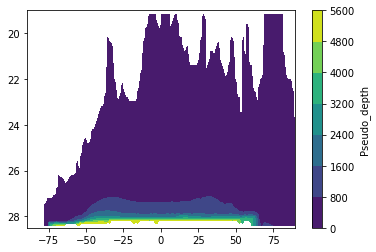

In [21]:
plt.contourf(lat2d,density2d,pseudo_z[1,:,:])
ax=plt.gca()
ax.invert_yaxis()
cb=plt.colorbar()
cb.set_label('Pseudo_depth')
plt.show()

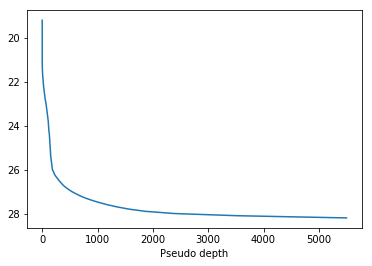

In [22]:
plt.plot(pseudo_z[0,:,90],density)
plt.gca().invert_yaxis()
plt.xlabel('Pseudo depth')
plt.show()

In [23]:
import sys
sys.path.append('/home/ysilvy/Density_bining/Yona_analysis/programs/')
from lib_remapping import remaptoz

In [24]:
var = fmod.variables['isonso'][:,:,:,:]
var_change = np.ma.average(var[-5:,:,:,:],axis=0)-np.ma.average(var[88:93,:,:,:],axis=0)

In [25]:
# Remap
fieldz=remaptoz(var_change,pseudo_z,targetz)

/home/ysilvy/.conda/envs/mypython3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


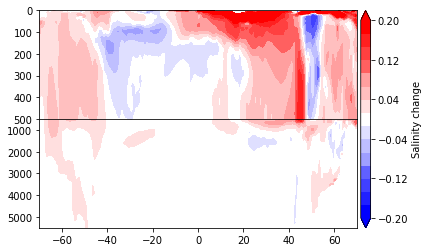

In [26]:
from maps_matplot_lib import custom_div_cmap
lat2d,targetz2d = np.meshgrid(lat,targetz)
cmap = custom_div_cmap()
levels=np.linspace(-0.2,0.2,16)
fig,ax = plt.subplots(2,1,sharex=True)
cnt0 = ax[0].contourf(lat2d,targetz2d,fieldz[1,:,:],cmap=cmap,levels=levels,extend='both')
ax[0].set_ylim([0,500])
ax[0].set_xlim([-70,70])
cnt1 = ax[1].contourf(lat2d,targetz2d,fieldz[1,:,:],cmap=cmap,levels=levels,extend='both')
ax[1].set_ylim([500,5500])
ax[0].invert_yaxis()
ax[1].invert_yaxis()
cb=plt.colorbar(cnt1,ax=ax.ravel().tolist(),ticks=levels[::3],fraction=0.04)
cb.set_label('Salinity change')
plt.subplots_adjust(hspace=0.001,right=0.86)
plt.show()

## Testing mean field remapping

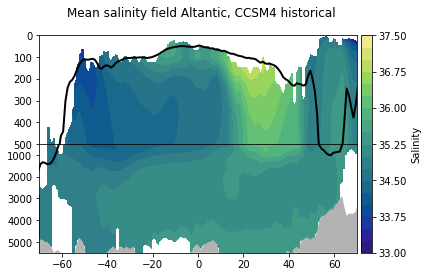

In [46]:
# CCSM4
import cmocean
# choose variable
var = fmod.variables['isonsoBowl'][:,:,:,:]
var_mean = np.ma.average(var[-55:,:,:,:],axis=0)
var_mean_z = remaptoz(var_mean,pseudo_z,targetz)
fmod1d = open_ncfile(indirh+'cmip5.CCSM4.historical.ensm.an.ocn.Omon.density.ver-v20121128_zon1D.nc')
bowlz = np.ma.average(fmod1d.variables['ptopdepth'][-55:,:,:],axis=0)
# Plot
fig,ax = plt.subplots(2,1,sharex=True)
levels=np.arange(33, 37.6, .25)
cmap = cmocean.cm.haline
cnt0 = ax[0].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
ax[0].plot(lat,bowlz[1,:],color='black', linewidth=2)
ax[0].set_ylim([0,500])
ax[0].set_xlim([-70,70])
cnt1 = ax[1].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
ax[1].plot(lat,bowlz[1,:],color='black', linewidth=2)
bathy_a = np.ma.max(depthmask_a, axis=1)
ax[1].fill_between(lat,[targetz[-1]]*len(lat),bathy_a[:],facecolor='0.7')
ax[1].set_ylim([500,5500])
ax[0].invert_yaxis()
ax[1].invert_yaxis()
cb=plt.colorbar(cnt1,ax=ax.ravel().tolist(),ticks=levels[::3],fraction=0.04)
cb.set_label('Salinity')
plt.subplots_adjust(hspace=0.001,right=0.86)
plt.suptitle('Mean salinity field Altantic, CCSM4 historical')
plt.show()

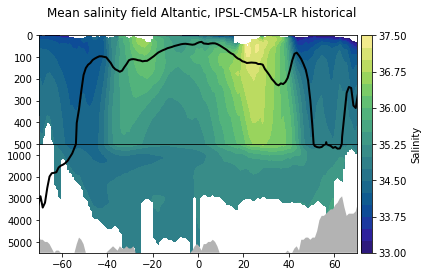

In [55]:
# IPSL-CM5A-LR
import cmocean
# choose variable
fipsl = open_ncfile(indirh+'cmip5.IPSL-CM5A-LR.historical.ensm.an.ocn.Omon.density.ver-v20111119_zon2D.nc')
var = fipsl.variables['isonso'][:,:,:,:]
var_mean = np.ma.average(var[-55:,:,:,:],axis=0)
var_mean_z = remaptoz(var_mean,pseudo_z,targetz)
fipsl1d = open_ncfile(indirh+'cmip5.IPSL-CM5A-LR.historical.ensm.an.ocn.Omon.density.ver-v20111119_zon1D.nc')
bowlz = np.ma.average(fipsl1d.variables['ptopdepth'][-55:,:,:],axis=0)
# Plot
fig,ax = plt.subplots(2,1,sharex=True)
levels=np.arange(33, 37.6, .25)
cmap = cmocean.cm.haline
cnt0 = ax[0].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
ax[0].plot(lat,bowlz[1,:],color='black', linewidth=2)
ax[0].set_ylim([0,500])
ax[0].set_xlim([-70,70])
cnt1 = ax[1].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
ax[1].plot(lat,bowlz[1,:],color='black', linewidth=2)
bathy_a = np.ma.max(depthmask_a, axis=1)
ax[1].fill_between(lat,[targetz[-1]]*len(lat),bathy_a[:],facecolor='0.7')
ax[1].set_ylim([500,5500])
ax[0].invert_yaxis()
ax[1].invert_yaxis()
cb=plt.colorbar(cnt1,ax=ax.ravel().tolist(),ticks=levels[::3],fraction=0.04)
cb.set_label('Salinity')
plt.subplots_adjust(hspace=0.001,right=0.86)
plt.suptitle('Mean salinity field Altantic, IPSL-CM5A-LR historical')
plt.show()

In [44]:
indirh

'/data/ericglod/Density_binning/Prod_density_april15/mme_hist/'

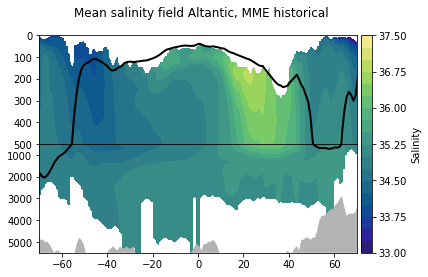

In [47]:
# Same with mme
# choose variable
fmme = open_ncfile(indirh+'cmip5.multimodel_Nat.historical.ensm.an.ocn.Omon.density_zon2D.nc')
var = fmme.variables['isonsoBowl'][:,:,:,:]
var_mean = np.ma.average(var[-55:,:,:,:],axis=0)
var_mean_z = remaptoz(var_mean,pseudo_z,targetz)
fmme1d = open_ncfile(indirh+'cmip5.multimodel_Nat.historical.ensm.an.ocn.Omon.density_zon1D.nc')
bowlz = np.ma.average(fmme1d.variables['ptopdepth'][-55:,:,:],axis=0)
# Plot
fig,ax = plt.subplots(2,1,sharex=True)
levels=np.arange(33, 37.6, .25)
cmap = cmocean.cm.haline
cnt0 = ax[0].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
ax[0].plot(lat,bowlz[1,:],color='black', linewidth=2)
ax[0].set_ylim([0,500])
ax[0].set_xlim([-70,70])
cnt1 = ax[1].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
ax[1].plot(lat,bowlz[1,:],color='black', linewidth=2)
bathy_a = np.ma.max(depthmask_a, axis=1)
ax[1].fill_between(lat,[targetz[-1]]*len(lat),bathy_a[:],facecolor='0.7')
ax[1].set_ylim([500,5500])
ax[0].invert_yaxis()
ax[1].invert_yaxis()
cb=plt.colorbar(cnt1,ax=ax.ravel().tolist(),ticks=levels[::3],fraction=0.04)
cb.set_label('Salinity')
plt.subplots_adjust(hspace=0.001,right=0.86)
plt.suptitle('Mean salinity field Altantic, MME historical')
plt.show()

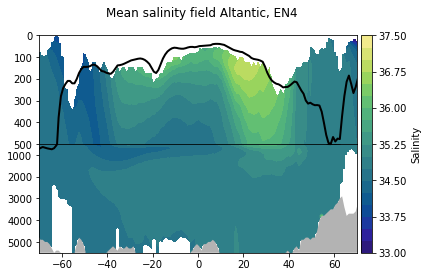

In [52]:
# Same with EN4
# choose variable
fEN4 = open_ncfile('/home/ericglod/Density_bining/test/EN4.mon.ocean.Omon.1900_2017.density.nc')
var = fEN4.variables['isonso'][:,:,:,:]
var_mean = np.ma.average(var[-68:-13:,:,:,:],axis=0)
bowlz = np.ma.average(fEN4.variables['ptopdepth'][-68:-13,:,:],axis=0)
bowlr = np.ma.average(fEN4.variables['ptopsigma'][-68:-13,:,:],axis=0)
# Mask above bowl in rho
for ilat in range(len(lat)):
    if np.ma.is_masked(bowlr[1,ilat]) == False :
        inda = np.ma.nonzero(bowlr[1,ilat]>=density)
        var_mean[1,inda,ilat] = np.ma.masked
    if np.ma.is_masked(bowlr[2,ilat]) == False :
        indp = np.ma.nonzero(bowlr[2,ilat]>=density)
        var_mean[2,indp,ilat] = np.ma.masked
    if np.ma.is_masked(bowlr[3,ilat]) == False :
        indi = np.ma.nonzero(bowlr[3,ilat]>=density)
        var_mean[3,indi,ilat] = np.ma.masked
var_mean_z = remaptoz(var_mean,pseudo_z,targetz)
# Plot
fig,ax = plt.subplots(2,1,sharex=True)
levels=np.arange(33, 37.6, .25)
cmap = cmocean.cm.haline
cnt0 = ax[0].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
ax[0].plot(lat,bowlz[1,:],color='black', linewidth=2)
ax[0].set_ylim([0,500])
ax[0].set_xlim([-70,70])
cnt1 = ax[1].contourf(lat2d,targetz2d,var_mean_z[1,:,:],cmap=cmap,levels=levels)
ax[1].plot(lat,bowlz[1,:],color='black', linewidth=2)
bathy_a = np.ma.max(depthmask_a, axis=1)
ax[1].fill_between(lat,[targetz[-1]]*len(lat),bathy_a[:],facecolor='0.7')
ax[1].set_ylim([500,5500])
ax[0].invert_yaxis()
ax[1].invert_yaxis()
cb=plt.colorbar(cnt1,ax=ax.ravel().tolist(),ticks=levels[::3],fraction=0.04)
cb.set_label('Salinity')
plt.subplots_adjust(hspace=0.001,right=0.86)
plt.suptitle('Mean salinity field Altantic, EN4')
plt.show()